# Preprocessing & Analysis of TSAD Evaluation Results

This notebook processes the performance results of the research paper:
Schmidl, S., Wenig, P., & Papenbrock, T. (2022). Anomaly detection in time series: A comprehensive evaluation. Proceedings of the VLDB Endowment, 15(9), 1779–1797. https://doi.org/10.14778/3538598.3538602
https://timeeval.github.io/evaluation-paper/

Purpose:
- To limit the results to the specific scope of this research.
- To perform data extraction, filtering, and analysis as required.

Author: Dennis Huber

Date: 09.07.2024

Usage:
- Download the evaluation results of the paper. Their data can be found here https://my.hidrive.com/share/ma4p8w4qqb#$/. You will need:
    - tsad-evaluation-results.csv
    - GutenTAG.zip/overview.yaml
- Ensure that the data files are correctly specified in the following codeblock, when reading.

In [1]:
# Specify your file locations here, if changed
TSAD_EVALUATION_RESULTS = 'datasets/tsad-evaluation-results.csv'
OVERVIEW_FILE = 'datasets/overview.yaml'

In [2]:
import pandas as pd
df_org = pd.read_csv(TSAD_EVALUATION_RESULTS)

## 1. Filter
This research only focuses on **univariate** datasets and algorithms that:
- are **unsupervised** or **semi-supervised**
- that run **without error**

In [3]:
def print_filter_result(original_set, subset, filter_type):
    """Prints the results of applying a filter to a dataset for verification.

    :param original_set: The original dataset containing the complete set of algorithms.
    :type original_set: pd.DataFrame
    :param subset: The filtered subset of the dataset after applying the filter.
    :type subset: pd.DataFrame
    :param filter_type: A description of the filter used, which will be included in the output to specify which filter caused the exclusions.
    :type filter_type: str

    :returns: None. This function prints the results directly to the console.
    """
    eliminated_elements = set(subset.algorithm).difference(set(original_set.algorithm))
    
    # Set is empty
    if not eliminated_elements:
        print(f"No algorithm was excluded by {filter_type}-Filter.")
    else:
        print(f"Algorithms excluded due to {filter_type}-Filter: \n")
    for e in eliminated_elements:
      print(f" - {e}\n")
    
    print(f"{original_set.shape[0] - subset.shape[0]} Dataset entries deleted.")

### 1.1 Filter Algorithms with errors

In [4]:
df_error_free = df_org.loc[df_org.error_category == "- OK -"]
print_filter_result(df_org, df_error_free, 'Error')

No algorithm was excluded by Error-Filter.
5347 Dataset entries deleted.


### 1.2 Filter to Univariate Datasets and Algorithms

In [5]:
df_uni_algo = df_error_free.loc[df_error_free.algo_input_dimensionality == "UNIVARIATE"]
print_filter_result(df_error_free, df_uni_algo, 'Algorithm Input Dim.')

df_uni_dataset = df_uni_algo.loc[df_uni_algo.dataset_input_dimensionality == "UNIVARIATE"]
print_filter_result(df_uni_algo, df_uni_dataset, 'Dataset Input Dim.')

No algorithm was excluded by Algorithm Input Dim.-Filter.
15853 Dataset entries deleted.
No algorithm was excluded by Dataset Input Dim.-Filter.
0 Dataset entries deleted.


### 1.3 Filter to Supervised Datasets and Algorithms

In [6]:
df_usup_algo = df_uni_dataset.loc[df_uni_dataset.algo_training_type != "SUPERVISED"]
df_usup_dataset = df_usup_algo.loc[df_usup_algo.dataset_training_type != "SUPERVISED"]

print_filter_result(df_uni_dataset, df_usup_algo, 'Algorithm Training Type')
print_filter_result(df_usup_algo, df_usup_dataset, 'Dataset Training Type')

No algorithm was excluded by Algorithm Training Type-Filter.
0 Dataset entries deleted.
No algorithm was excluded by Dataset Training Type-Filter.
82 Dataset entries deleted.


After applying all the filters we double check if no algorithm was deleted by comparing the original DataFrame with the last filter iteration

In [7]:
print(set(df_usup_dataset.algorithm).difference(set(df_org.algorithm)))

set()


There is no difference in algorithms, so no algorithm was deleted - only instances. Now we check how many instances were deleted in order to see the amount of evaluation results left for analyiss 

In [8]:
print(f"{df_org.shape[0] - df_usup_dataset.shape[0]} of {df_org.shape[0]} deleted, {df_usup_dataset.shape[0]} remaining. {df_usup_dataset.shape[0] / df_org.shape[0] * 100}% of original size.")

21282 of 45131 deleted, 23849 remaining. 52.8439431876094% of original size.


### Result of Filtering
We conclude
- No algorithm is excluded by following this filtering method
- 47% of the original evaluation results were deleted

In [9]:
df = df_usup_dataset.copy()

## 2. Augment Evaluation Results with additional Information

The authors provide more information about the used datasets in evaluation. Such information is important for further analysis, which is why we simply add it to the evaluation results table. The algorithms were evaluated on real data from different datasets and on synthetic data, generated by their own GutenTAG library. In order to get a better sense for the effect of different anomaly types, we add information to the synthetic dataset. For each instance that was evaluated on the synthetic dataset, we want to know:
- does the data contain more than one type of anomaly (e.g. trend and threshold)
- If only one type appears, what anomaly type is it.

By doing so we can compare and analyze the evaluation results yielded on one specific type of anomaly. Since in this case the data is synthetic we can formulate theses on their effect (e.g. does a certain algorithm excel on a certain anomaly type)

In [10]:
import yaml

with open(OVERVIEW_FILE, 'r') as file:
    metadata_raw = yaml.load(file, Loader=yaml.FullLoader)
    
# Initialize an empty list to store the information
collected_data = []

# Iterate through each element in 'generated-timeseries'
for el in metadata_raw['generated-timeseries']:
    name = el['name']
    anomalies = el['anomalies']
    collected_data.append({
            "name": name,
            "anomaly_kind": [anomaly['kinds'][0]['kind'] for anomaly in anomalies]
    })


# Convert the list of dictionaries to a DataFrame
metadata = pd.DataFrame(collected_data)
metadata["num_anomalies"] = metadata.anomaly_kind.apply(len) # number of anomalies in dataset
metadata["unique_anomaly_type"] = metadata.anomaly_kind.apply(lambda x: len(set(x)) == 1)

metadata["unique_anomaly_type"].value_counts(normalize=True)

unique_anomaly_type
True     0.761658
False    0.238342
Name: proportion, dtype: float64

Within the synthetic GutenTAG dataset 76% contain only one type of anomaly (unique anomaly type).

In [27]:
# Add the metadata to the evaluation table (unique and multiple anomaly types)
if set(metadata['name']) == set(metadata['name'].drop_duplicates()): # check if the 'name' column can be used as a mapping key (is unique for each instance)
    df_agg = df.join(metadata.rename(columns={'name': 'dataset'}).set_index('dataset'), on='dataset')
else:
    raise ValueError('The name of the dataset is not unique and can not be used to map the metadata to the evaluation results.')

df_agg.unique_anomaly_type.value_counts(dropna=False)

unique_anomaly_type
NaN      18600
True      3932
False     1317
Name: count, dtype: int64

The evaluation table now contains additional information about the instances of the synthetic GutenTAG dataset. The other instances are marked `NaN` since it is not yet clear if they have different anomaly types embedded.

In [28]:
df = df_agg.copy()

# Hypothesis 1: Anomaly Nature and Characteristic influences Algorithm Performance

We hypothesize that an algorithm's performance is affected by the type of anomaly it is trying to detect. Specifically, some could argue that algorithms with a smaller context size may have difficulty identifying anomalies that occur over longer periods (trend anomaly). This is because their limited view might not capture the extended patterns of these long-duration anomalies effectively.

In order to test the hypothesis we:
- Limit the evaluation results to the artificial "GutenTag" dataset 
- Only use evaluation result instances that were yielded on time-series with only one type of anomaly
- Finally, we compare the anomaly type with performance, grouped by the algorithm family. For grouping we use the taxonomy of Schmidl, S., Wenig, P., & Papenbrock, T. (2022). We also rely on the authors proposal to use _Receiver Operating Characteristic Area Under the Curve_ (ROC_AUC) as a performance metric for comparison.

**Finding:** Relevant influence

In [33]:
df_h1.head(1)

,algorithm,collection,dataset,algo_training_type,algo_input_dimensionality,dataset_training_type,dataset_input_dimensionality,train_preprocess_time,train_main_time,execute_preprocess_time,...,RANGE_PR_AUC,AVERAGE_PRECISION,overall_time,error_category,algo_family,algo_area,algo_display_name,anomaly_kind,num_anomalies,unique_anomaly_type
2,ARIMA,GutenTAG,cbf-diff-count-1,UNSUPERVISED,UNIVARIATE,UNSUPERVISED,UNIVARIATE,NaN,NaN,NaN,...,0.016521,0.014368,72.992341,- OK -,forecasting,Statistics (Regression & Forecasting),ARIMA,[pattern],1.0,True


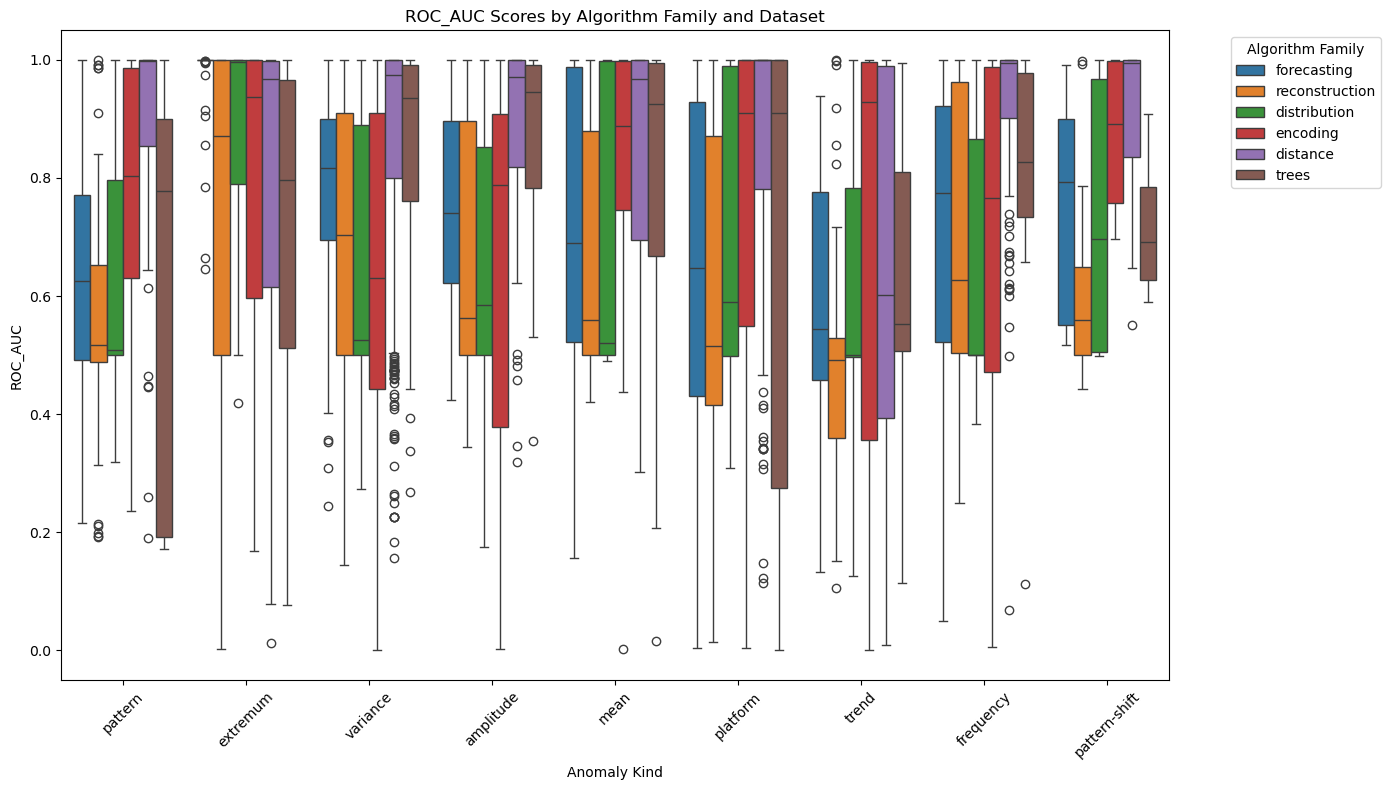

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtering to synthetic time-series that only contain one type of anomaly
df_h1 = df.loc[df.unique_anomaly_type == True]
df_h1.loc[:, 'anomaly_kind'] = df_h1['anomaly_kind'].apply(lambda x: x[0]) # remove list type of column anomaly_kind since now its unique kind (one list entry)

# Visualizing performance over anomaly type per algorithm family
plt.figure(figsize=(14, 8)) # Set the figure size for better readability
sns.boxplot(x='anomaly_kind', y='ROC_AUC', hue='algo_family', data=df_h1)
plt.xticks(rotation=45)
plt.title('ROC_AUC Scores by Algorithm Family and Dataset')
plt.xlabel('Anomaly Kind')
plt.ylabel('ROC_AUC')
plt.legend(title='Algorithm Family', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Theory for best performers based on graph:

| Anomaly Kind    | Algorithm Family    |
|-----------------|---------------------|
| pattern         | distance            |
| extremum        | forecasting         |
| variance        | distance, trees     |
| amplitude       | distance, trees     |
| mean            | distance            |
| platform        | distance            |
| trend           | encoding            |
| frequency       | distance            |
| pattern-shift   | distance            |

#### ANOVA
Now we analyze the interactions and findings from the graph further with an ANOVA to check the hypothesis

In [37]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Perform two-way ANOVA
model = ols('ROC_AUC ~ C(anomaly_kind) + C(algo_family) + C(anomaly_kind):C(algo_family)', data=df_h1).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

anova_table

,sum_sq,df,F,PR(>F)
C(anomaly_kind),7.245498,8.0,19.143921,1.681166e-28
C(algo_family),23.600147,5.0,99.769398,3.123312e-99
C(anomaly_kind):C(algo_family),12.213155,40.0,6.453875,2.135305e-32
Residual,183.465814,3878.0,NaN,NaN


We conclude:
- Both anomaly_kind and algo_family have significant main effects on the dependent variable.
- There is a significant interaction effect between anomaly_kind and algo_family, meaning that the kind of anomaly on the dependent variable varies depending on the algorithm family.